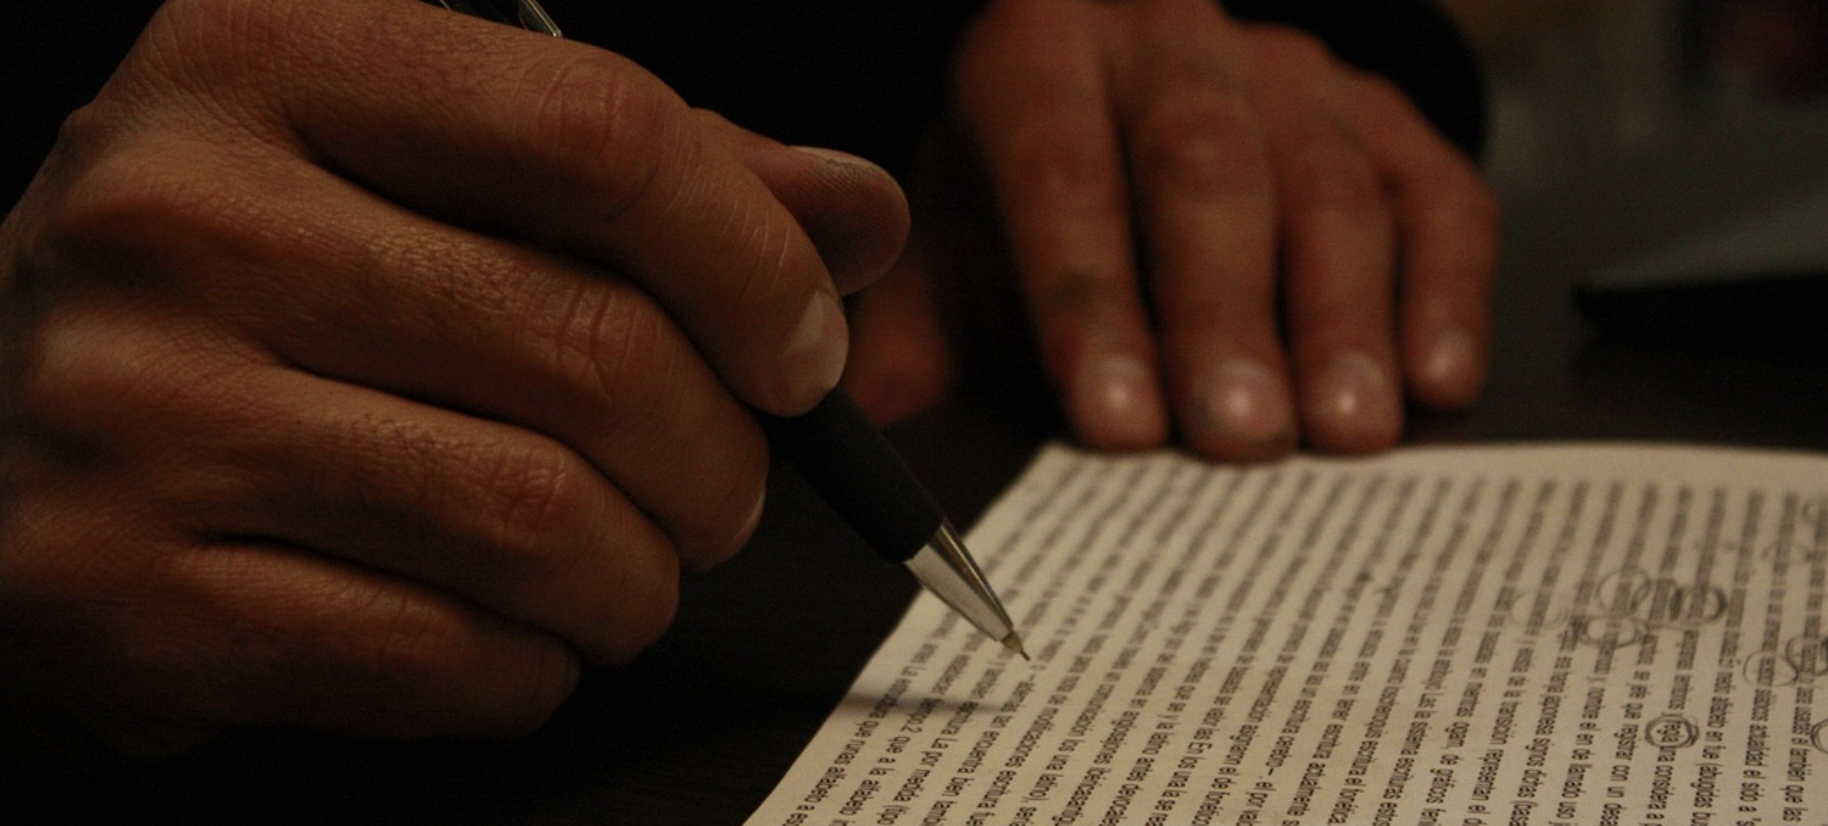

# Exploration 6. LSTM Prediction
---
# (프로젝트) 멋진 작사가 만들기

## [루브릭]
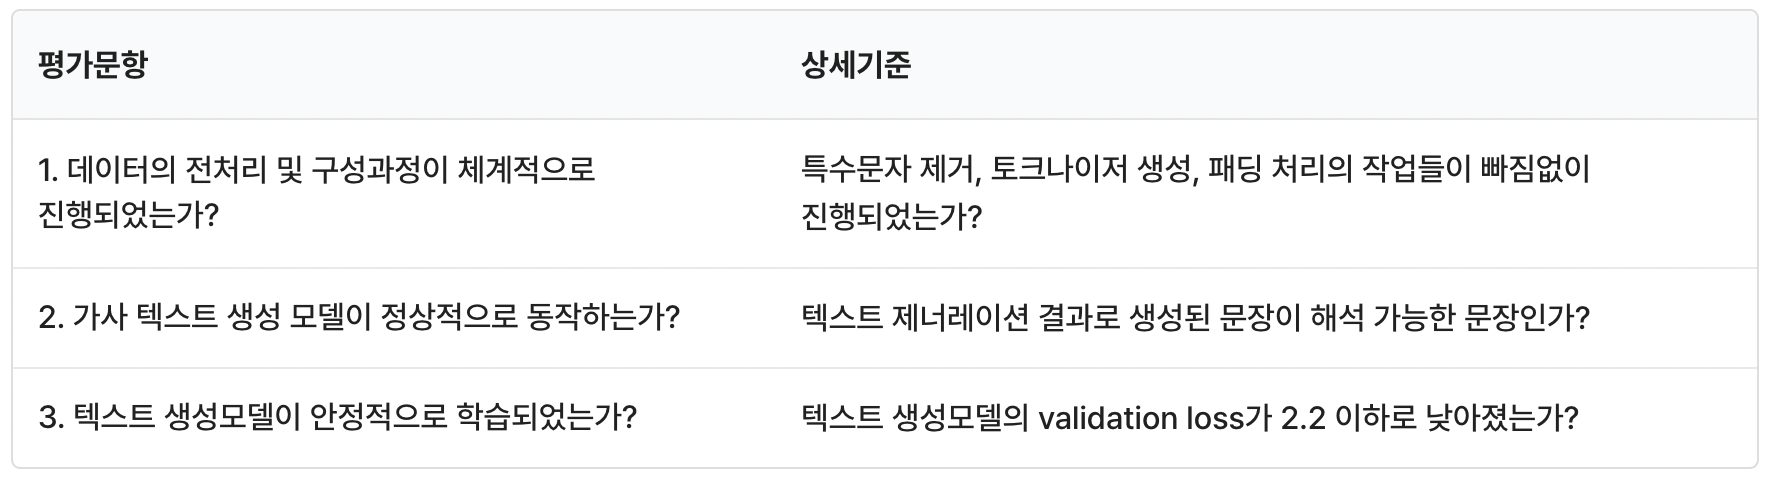

## Step 1. 데이터 읽어오기

In [14]:
import glob
import os

In [15]:
txt_file_path = '/Users/joowanha/PycharmProjects/AIFFEL/lyrics/data/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() 
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '', 'All of this and more is for you']


## Step 2. 데이터 정제

먼저 특수문자가 포함된 내용을 바탕으로 어떤 문장들이 포함되어 있는지 확인해 도록 하겠습니다.

In [16]:
raw_corpus[:10]

['',
 '',
 'All of this and more is for you',
 'With love, sincerity and deepest care',
 'My life with you I share',
 '',
 '',
 'Ever since I met you, baby',
 "I've been wantin' to lay you down",
 "But it's so hard to get you"]

맨 처음 보이는 것이 공백줄('')이 보입니다. 해당 공백들을 먼저 다 제거하도록 하겠습니다. 

In [17]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0 : continue
    corpus.append(sentence)

In [18]:
corpus[:10]

['All of this and more is for you',
 'With love, sincerity and deepest care',
 'My life with you I share',
 'Ever since I met you, baby',
 "I've been wantin' to lay you down",
 "But it's so hard to get you",
 'Baby, when you never come around',
 'Every day that you keep it away',
 'It only makes me want it more',
 'Ooh baby, just say the word']

특수 문자가 포함된 다른 문장들도 살펴보도록 하겠습니다. 

In [19]:
import re

In [20]:
pattern = re.compile("[^a-zA-Z?.!,\s]+")

for i, sentence in enumerate(corpus):
    sentence_stripped = sentence.strip()
    for special_letters in re.finditer(pattern, sentence_stripped):
        if i < 30:
            if special_letters.group(0):
                print(sentence_stripped)
        else : break

I've been wantin' to lay you down
I've been wantin' to lay you down
But it's so hard to get you
And I'll be at your door
Fallin', fallin', fallin' in love
Fallin', fallin', fallin' in love
Fallin', fallin', fallin' in love
I'm fallin', baby, deeper every day
I'm fallin', baby, deeper every day
(In love)
(In love)
You're breakin' my heart and takin' me away
You're breakin' my heart and takin' me away
You're breakin' my heart and takin' me away
(In love)
(In love)
I'm fallin' baby, girl, what can I do?
I'm fallin' baby, girl, what can I do?
I just can't be without you
There's been somethin' inside of me
There's been somethin' inside of me
That keeps me wantin' you
Baby, won't you set me free?
And I'll take off yours
There's no one in the world, baby


나머지 특수문자가 포함되어 표현된 부분은 특수문자는 삭제하되 내용은 유지하는 것이 바람직 할 것 같아 그래도 유리하고 불필요한 특수 문자만 제거하도록 하겠습니다. 특히 ' 가 포함된 문장은 단어 하나로 그대로 유지하는 편이 문장 생성 및 의미 유지에 바람직할 것으로 판단되어 유지하도록 하겠습니다.

In [21]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r'([?.!,])', r' \1 ', sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r'[^a-zA-Z?.!,\']+', ' ', sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

In [22]:
# 문장 길이가 0이거나 (계산 편의를 위해) 문장 길이가 12단어 이상의 경우, 그리고 동일한 문장은 제외하고 전처리 진행
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0 : continue
    elif len(sentence.split(' ')) >= 12 : continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
corpus = list(set(corpus))

In [23]:
corpus[:20]

['<start> but she just makes it all too concise and too clear <end>',
 '<start> i will be there <end>',
 "<start> they mad i'm on top of my game and they down <end>",
 "<start> no i don't have a gun <end>",
 '<start> japanese say time ooh ooh , alright alright , <end>',
 '<start> with my sycamore style more sicker than yours <end>',
 '<start> you grow up quick when ya grow up poor <end>',
 "<start> don't cry , don't cry , don't cry oh , no , no , no <end>",
 "<start> she's got that vibe <end>",
 "<start> for the mother's restless son <end>",
 '<start> two peak patek , no palay <end>',
 "<start> living together's gonna be a lot of re arranges <end>",
 '<start> i stop to think at a wishing well <end>',
 '<start> baby , baby , baby , baby <end>',
 "<start> you can't fool the youths <end>",
 "<start> so he don't want nobody else <end>",
 "<start> for i couldn't make it alone <end>",
 '<start> you just listen to this hustlers story as we proceed <end>',
 '<start> temptation , temptation , t

## Step 3. 평가 데이터셋 분리

앞 교육 과정에서 만든 tokenize() 함수를 활용하여 데이터를 Tensor로 변환하도록 하고 단어장의 크기는 12,000으로 설정하도록 하겠습니다.

In [42]:
import tensorflow as tf

In [43]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,
        filters=' ',
        oov_token='<unk>'
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    print(tensor, tokenizer)
    return tensor, tokenizer

In [44]:
tensor, tokenizer = tokenize(corpus)

[[  2  29  49 ...   0   0   0]
 [  2   6  76 ...   0   0   0]
 [  2  39 557 ...   0   0   0]
 ...
 [  2  49 833 ...   0   0   0]
 [  2   6 165 ...   0   0   0]
 [  2 867   1 ...   0   0   0]] <keras.preprocessing.text.Tokenizer object at 0x28dafdd30>


In [45]:
tensor[0]

array([  2,  29,  49,  31, 483,  14,  23,  98,   1,   8,  98, 872,   3,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

In [46]:
for idx in tokenizer.index_word :
    print(idx, ":", tokenizer.index_word[idx])
    
    if idx >= 20: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : the
6 : i
7 : you
8 : and
9 : a
10 : to
11 : me
12 : my
13 : in
14 : it
15 : .
16 : that
17 : of
18 : on
19 : your
20 : i'm


In [47]:
# !pip install scikit-learn

In [48]:
from sklearn.model_selection import train_test_split

전체 데이터를 source와 target 데이터로 분리 후 20%를 테스트 데이터로 따로 보관하도록 하겠습니다.

In [49]:
src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:]

In [50]:
# train : test = 8: 2로 분리
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input,
                                                   test_size=0.2,
                                                   random_state=1)

In [51]:
print(f"enc_train size : {len(enc_train):>6}")
print(f"enc_val size   : {len(enc_val):>6}")
print(f"dec_train size : {len(dec_train):>6}")
print(f"dec_val size   : {len(dec_val):>6}")

enc_train size :  78284
enc_val size   :  19572
dec_train size :  78284
dec_val size   :  19572


## Step 4. 인공지능 만들기

### [1차] Baseline 모델링

In [52]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

In [53]:
VOCAB_SIZE = tokenizer.num_words + 1

In [54]:
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [55]:
class LyricsGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model_1st = LyricsGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)

In [56]:
for src_sample, tgt_sample in dataset.take(1): break

In [57]:
model_1st(src_sample)

<tf.Tensor: shape=(256, 28, 12001), dtype=float32, numpy=
array([[[ 2.63993017e-04,  5.52201018e-05,  1.16208830e-05, ...,
          2.18932604e-04, -6.83070321e-05, -1.51156119e-05],
        [ 4.25486505e-04,  9.72984344e-05,  1.36064336e-04, ...,
          5.01277798e-04, -3.57044861e-04,  3.40624800e-04],
        [ 3.24829540e-04,  4.61214440e-05,  4.06680745e-04, ...,
          4.35161084e-04, -7.64146971e-04,  4.37503128e-04],
        ...,
        [ 9.48254019e-04, -1.78042566e-03, -1.03563152e-03, ...,
         -2.88476469e-03,  2.82753888e-03, -4.24475130e-03],
        [ 1.04479003e-03, -1.91390712e-03, -1.05338218e-03, ...,
         -2.92561715e-03,  2.91072368e-03, -4.32880316e-03],
        [ 1.13093632e-03, -2.03135982e-03, -1.06604723e-03, ...,
         -2.95794406e-03,  2.98351678e-03, -4.39419178e-03]],

       [[ 2.63993017e-04,  5.52201018e-05,  1.16208830e-05, ...,
          2.18932604e-04, -6.83070321e-05, -1.51156119e-05],
        [ 5.03281597e-04,  9.01656604e-05, -1

In [58]:
model_1st.summary()

Model: "lyrics_generator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  3072256   
                                                                 
 lstm_2 (LSTM)               multiple                  5246976   
                                                                 
 lstm_3 (LSTM)               multiple                  8392704   
                                                                 
 dense_1 (Dense)             multiple                  12301025  
                                                                 
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [60]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [62]:
# Reduce learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0003)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, reduction='none') # 클래스 분류 문제에서 softmax 함수를 거치면 from_logits = False(default값),그렇지 않으면 from_logits = True.

model_1st.compile(loss=loss, optimizer=optimizer)


history_1st = model_1st.fit(dataset, epochs=40, validation_data=(enc_val, dec_val), callbacks=[learning_rate_reduction, early_stop])

Epoch 1/40


2022-11-27 23:24:20.336191: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-27 23:24:20.338757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-27 23:24:20.576111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-27 23:24:20.618674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-27 23:24:21.231229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-27 23:24:22.034582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


305/305 [==============================] - ETA: 0s - loss: 1.9655

2022-11-27 23:27:50.456279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-27 23:27:50.550666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-27 23:27:50.664146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


305/305 [==============================] - 240s 780ms/step - loss: 1.9655 - val_loss: 1.6654 - lr: 0.0010
Epoch 2/40
305/305 [==============================] - 238s 779ms/step - loss: 1.6076 - val_loss: 1.5819 - lr: 0.0010
Epoch 3/40
305/305 [==============================] - 234s 766ms/step - loss: 1.5406 - val_loss: 1.5388 - lr: 0.0010
Epoch 4/40
305/305 [==============================] - 233s 764ms/step - loss: 1.4932 - val_loss: 1.5122 - lr: 0.0010
Epoch 5/40
305/305 [==============================] - 1195s 4s/step - loss: 1.4545 - val_loss: 1.4941 - lr: 0.0010
Epoch 6/40
305/305 [==============================] - 854s 3s/step - loss: 1.4193 - val_loss: 1.4808 - lr: 0.0010
Epoch 7/40
305/305 [==============================] - 1110s 4s/step - loss: 1.3870 - val_loss: 1.4690 - lr: 0.0010
Epoch 8/40
305/305 [==============================] - 233s 764ms/step - loss: 1.3563 - val_loss: 1.4616 - lr: 0.0010
Epoch 9/40
305/305 [==============================] - 1403s 5s/step - loss: 1.3266

In [67]:
# ! pip install matplotlib

In [70]:
import matplotlib.pyplot as plt

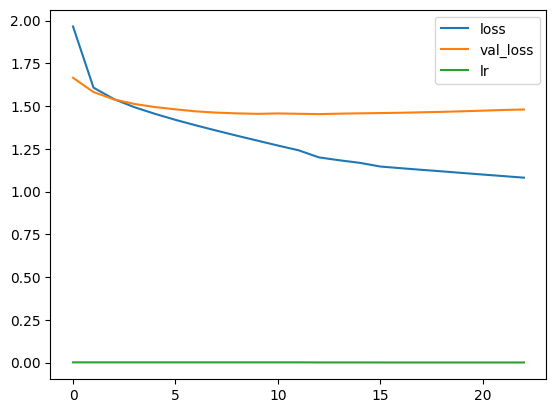

In [71]:
plt.figure()

for k,v in history_1st.history.items():
    plt.plot(history_1st.history[k], label=k)
plt.legend()
plt.show()

마지막으로 멋진 모델이 생성한 가사 한 줄을 제출하시길 바랍니다!

In [79]:
def generate_lyrics(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    while True:
        predict = model(test_tensor)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break
        
    generated = ""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
        
    return generated

In [80]:
generate_lyrics(model_1st, tokenizer, init_sentence="<start> i love", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

'<start> i love you , i love you , i love you <end> '

In [93]:
generate_lyrics(model_1st, tokenizer, init_sentence="<start> hello", max_len=20)

'<start> hello , hello , hello , hello , hello , hello , hello , hello , hello , hello '

In [108]:
generate_lyrics(model_1st, tokenizer, init_sentence="<start> because you", max_len=20)

"<start> because you know that i don't know <end> "

In [91]:
generate_lyrics(model_1st, tokenizer, init_sentence="<start> but i", max_len=20)

'<start> but i know that i was wrong <end> '

In [90]:
generate_lyrics(model_1st, tokenizer, init_sentence="<start> it is beautiful", max_len=20)

"<start> it is beautiful , i don't know what i do <end> "

### [2차] layer 추가, embedding 및 hidden size 증대

In [85]:
class LyricsGenerator_2nd(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_3 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.rnn_3(out)        
        out = self.linear(out)
        
        return out
    
embedding_size = 512
hidden_size = 2048
model_2nd = LyricsGenerator_2nd(tokenizer.num_words + 1, embedding_size, hidden_size)

In [86]:
# Reduce learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0003)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, reduction='none') # 클래스 분류 문제에서 softmax 함수를 거치면 from_logits = False(default값),그렇지 않으면 from_logits = True.

model_2nd.compile(loss=loss, optimizer=optimizer)


history_2nd = model_1st.fit(dataset, epochs=15, validation_data=(enc_val, dec_val), callbacks=[early_stop])

Epoch 1/15
305/305 [==============================] - 233s 762ms/step - loss: 1.1753 - val_loss: 1.4571
Epoch 2/15
305/305 [==============================] - 233s 763ms/step - loss: 1.1648 - val_loss: 1.4614
Epoch 3/15
305/305 [==============================] - 2262s 7s/step - loss: 1.1551 - val_loss: 1.4650
Epoch 4/15
305/305 [==============================] - 5102s 17s/step - loss: 1.1458 - val_loss: 1.4705
Epoch 5/15
305/305 [==============================] - 3909s 13s/step - loss: 1.1364 - val_loss: 1.4759
Epoch 6/15
305/305 [==============================] - 5273s 17s/step - loss: 1.1268 - val_loss: 1.4795
Epoch 7/15
305/305 [==============================] - 4193s 14s/step - loss: 1.1173 - val_loss: 1.4846
Epoch 8/15
305/305 [==============================] - 3445s 11s/step - loss: 1.1079 - val_loss: 1.4904
Epoch 9/15
305/305 [==============================] - 232s 761ms/step - loss: 1.0983 - val_loss: 1.4955
Epoch 10/15
305/305 [==============================] - 232s 762ms/step 

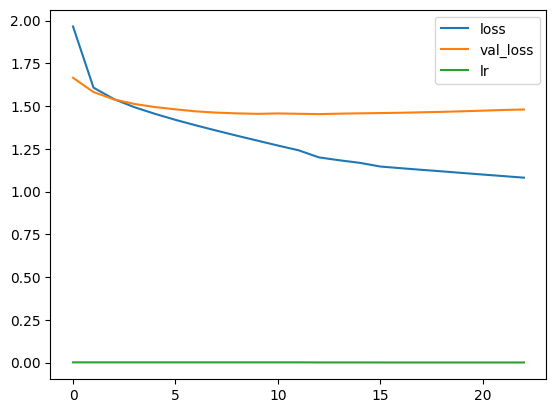

In [87]:
plt.figure()

for k,v in history_1st.history.items():
    plt.plot(history_1st.history[k], label=k)
plt.legend()
plt.show()

In [89]:
generate_lyrics(model_2nd, tokenizer, init_sentence="<start> hello", max_len=20)

"<start> hello sometime headlines headlines headlines headlines pawns pawns pawns pawns flashlight flashlight eagle's eagle's eagle's eagle's eagle's beating beating "

In [114]:
generate_lyrics(model_2nd, tokenizer, init_sentence="<start> because of you", max_len=20)

"<start> because of you root root root root pill pill pill pill tryin tryin tryin smile's smile's smile's hippy hippy "

## 회고  
- 기본적으로 NLP 관련 머신러닝의 경우 처리 데이터 및 vector 차원수가 높아 training 시간이 매우 오래 걸려 gpu support 세팅을 하여 training을 수행했습니다. 아쉽게도 Mac OS Apple silicon의 경우 multi GPU support는 되지 않아 시간 단축을 추가적으로 하지 못해 아쉬움이 남습니다.   
   Mac OS GPU support 세팅 : https://developer.apple.com/metal/tensorflow-plugin/  
- 2차에서는 layer 수와 embedding, hidden size를 증대해 보았는데, 초기 시작값은 낮은 loss에서 시작했으나 1차 대비 더 좋은 성능을 보인다고 말하기는 어려운 것 같습니다. 테스트 문장을 만들어 본 경우에도 1차의 결과가 좀 더 자연스럽게 나온 것을 확인할 수 있습니다.